In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\douly\appdata\local\temp\pip-req-build-urmdz7el
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369570 sha256=54eca7d43e62f4d984a950209092628d359bb167a316c568ddc9ecb0d1e8f322
  Stored in directory: C:\Users\douly\AppData\Local\Temp\pip-ephem-wheel-cache-54ze33y9\wheels\3f\7c\a4\9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\douly\AppData\Local\Temp\pip-req-build-urmdz7el'

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Forward Hook: Activations captured.
유사도 확률: [[1.]]
Selected Text: 'hairs' with similarity score: 38.28125
Backward Hook: Gradients captured.
Forward Hook: Activations captured.
Score for class 0: -0.0290069580078125
Backward Hook: Gradients captured.
Weights shape: torch.Size([1, 2048, 1, 1]), Weights stats: mean=9.5367431640625e-07, std=0.00016498565673828125
CAM stats: min=0.0, max=1.0, mean=0.1888427734375, std=0.2802734375


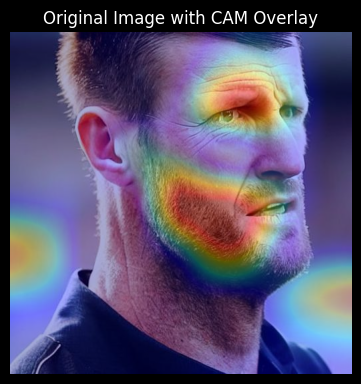

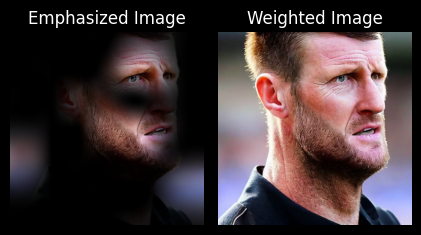

In [2]:
# 필요한 라이브러리 설치 (필요한 경우)
# !pip install torch torchvision
# !pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib
# !pip install Pillow
# !pip install requests

import torch
import torch.nn as nn
from torchvision import models, transforms
import clip
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO


class GradCAM:
    def __init__(self, model, target_layer):
        """
        Grad-CAM을 위한 클래스 초기화

        Args:
            model (torch.nn.Module): 모델
            target_layer (torch.nn.Module): Grad-CAM을 적용할 대상 레이어
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
            print("Forward Hook: Activations captured.")

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
            print("Backward Hook: Gradients captured.")

        # Forward hook
        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        # Backward hook
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)

    def generate_cam(self, input_tensor, class_idx=None):
        """
        Grad-CAM 히트맵 생성

        Args:
            input_tensor (torch.Tensor): 입력 이미지 텐서
            class_idx (int, optional): 타겟 클래스 인덱스. 지정하지 않으면 예측된 클래스를 사용

        Returns:
            numpy.ndarray: 히트맵
        """
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # 클래스에 대한 점수
        score = output[:, class_idx]
        print(f"Score for class {class_idx}: {score.item()}")
        score.backward()

        # 가중치 계산: global average pooling of gradients
        weights = torch.mean(
            self.gradients, dim=[2, 3], keepdim=True
        )  # [batch, channels, 1, 1]
        print(
            f"Weights shape: {weights.shape}, Weights stats: mean={weights.mean().item()}, std={weights.std().item()}"
        )
        cam = torch.sum(
            weights * self.activations, dim=1, keepdim=True
        )  # [batch, 1, H, W]
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 히트맵을 0-1 범위로 정규화
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        print(
            f"CAM stats: min={cam.min()}, max={cam.max()}, mean={cam.mean()}, std={cam.std()}"
        )
        return cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()


def preprocess_image(image_path, preprocess):
    """
    이미지를 전처리

    Args:
        image_path (str): 이미지 경로 또는 URL
        preprocess (callable): CLIP 전처리 함수

    Returns:
        torch.Tensor: 전처리된 이미지 텐서
        PIL.Image: 원본 이미지
    """
    try:
        if image_path.startswith("http://") or image_path.startswith("https://"):
            response = requests.get(image_path)
            response.raise_for_status()  # HTTP 오류가 있는지 확인
            image = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            image = Image.open(image_path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0)  # 배치 차원 추가
        return image_input, image
    except requests.exceptions.RequestException as e:
        print(f"이미지 다운로드 중 오류 발생: {e}")
        raise
    except UnidentifiedImageError:
        print(
            "이미지 파일을 식별할 수 없습니다. URL을 확인하거나 로컬 파일을 사용해보세요."
        )
        raise
    except Exception as e:
        print(f"이미지 로드 중 예기치 않은 오류 발생: {e}")
        raise


def show_cam_on_image(img: np.ndarray, mask: np.ndarray, alpha: float = 0.5):
    """
    이미지 위에 Grad-CAM 히트맵을 시각화

    Args:
        img (numpy.ndarray): 원본 이미지 (0-1 범위)
        mask (numpy.ndarray): 히트맵 (0-1 범위)
        alpha (float): 히트맵의 투명도
    """
    heatmap = plt.get_cmap("jet")(mask)[:, :, :3]  # RGB
    heatmap = np.uint8(heatmap * 255)
    overlay = heatmap * alpha + img * 255
    overlay = overlay / np.max(overlay)
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()


def main():
    # CLIP 모델 및 전처리기 로드
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # ResNet 기반 CLIP 모델 로드
    model, preprocess = clip.load("RN101", device=device)
    model.eval()  # 평가 모드로 설정

    # 이미지 로드
    image_url = "https://raw.githubusercontent.com/KimEunOh/image/main/image/10004122_1982-03-17_2011.jpg"

    try:
        input_tensor, original_image = preprocess_image(image_url, preprocess)
    except Exception as e:
        print("이미지 로드에 실패했습니다. 프로그램을 종료합니다.")
        return

    input_tensor = input_tensor.to(device)

    # 이미지 인코더에서 마지막 convolutional 레이어 찾기
    target_layer = model.visual.layer4  # ResNet의 마지막 레이어

    # Grad-CAM 객체 생성
    grad_cam = GradCAM(model.visual, target_layer)

    # 예시: 여러 텍스트 입력
    texts = ["hairs"]
    text_tokens = clip.tokenize(texts).to(device)

    # 유사도 계산
    # 회색으로 표시되더라도, 지우면 오류발생
    logits_per_image, logits_per_text = model(input_tensor, text_tokens)
    similarity_score = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    print(f"유사도 확률: {similarity_score}")

    # 가장 높은 확률을 가진 텍스트 선택
    top_idx = similarity_score[0].argmax()
    top_text = texts[top_idx]
    similarity_score = logits_per_image[0, top_idx].item()
    print(f"Selected Text: '{top_text}' with similarity score: {similarity_score}")

    # Grad-CAM 히트맵 생성 (클래스 인덱스는 텍스트 쪽)
    # CLIP은 멀티모달 모델이므로, Grad-CAM 적용을 위해 특정 텍스트와의 유사도에 대한 그래디언트 필요
    # 따라서, 유사도 점수에 대한 그래디언트를 사용
    model.zero_grad()

    # 유사도에 대한 점수
    score = logits_per_image[:, top_idx]
    score.backward()

    # Grad-CAM 히트맵 생성
    cam = grad_cam.generate_cam(input_tensor, class_idx=top_idx)

    # 원본 이미지와 히트맵 시각화
    # 원본 이미지를 numpy 배열로 변환 (0-1 범위)
    original_image_np = np.array(original_image) / 255.0

    # 히트맵을 원본 이미지 크기에 맞게 리사이즈
    cam_resized = np.uint8(cam * 255)
    try:
        # Pillow 버전에 따라 Resampling 사용 또는 LANCZOS 사용
        try:
            resample = Image.Resampling.LANCZOS  # Pillow 10.0.0 이상
        except AttributeError:
            resample = Image.LANCZOS  # 이전 버전
        cam_resized = Image.fromarray(cam_resized).resize(original_image.size, resample)
    except AttributeError:
        # 만약 LANCZOS도 없다면 ANTIALIAS 사용
        cam_resized = Image.fromarray(cam_resized).resize(
            original_image.size, Image.ANTIALIAS
        )
    cam_resized = np.array(cam_resized) / 255.0

    # 시각화
    plt.figure(figsize=(15, 15))

    # 1. Grad-CAM 히트맵을 원본 이미지에 오버레이
    plt.subplot(1, 3, 1)
    plt.title("Original Image with CAM Overlay")
    show_cam_on_image(original_image_np, cam_resized, alpha=0.5)

    # 2. 히트맵을 곱한 강조된 이미지
    plt.subplot(1, 3, 2)
    plt.title("Emphasized Image")
    emphasized_image = original_image_np * cam_resized[:, :, np.newaxis]
    plt.imshow(emphasized_image)
    plt.axis("off")

    # 3. 원본 이미지에 히트맵을 추가한 이미지 (채널 결합)
    plt.subplot(1, 3, 3)
    plt.title("Weighted Image")
    weighted_image = np.concatenate(
        [original_image_np, cam_resized[:, :, np.newaxis]], axis=2
    )
    plt.imshow(weighted_image[:, :, :3])  # RGB 채널만 표시
    plt.axis("off")

    # 전체 시각화
    plt.tight_layout()
    plt.show()

    # 후처리: Grad-CAM 후 후크 제거
    grad_cam.remove_hooks()


if __name__ == "__main__":
    main()

In [ ]:
import os
import torch

# PyTorch Hub 캐시 경로
cache_dir = os.path.expanduser("~/.cache/")
print(f"PyTorch Hub Cache Directory: {cache_dir}")

# 저장된 파일 확인
if os.path.exists(cache_dir):
    print("Saved Models:")
    for f in os.listdir(cache_dir):
        print(f"- {f}")
else:
    print("No models have been downloaded yet.")

PyTorch Hub Cache Directory: C:\Users\douly/.cache/
Saved Models:
- clip
- huggingface
- tooling
- torch
